In [55]:
# %pip install tensorflow
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install pydot

In [56]:
from PIL import Image
from pathlib import Path
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg", ".jpeg", ".bmp"]


def is_valid_image_pillow(file_name):
    try:
        with Image.open(file_name) as img:
            img.verify()
            img = Image.open(file_name)
            if not img.format.lower() in ['png', 'jpeg', 'bmp']:
                print(f"{file_name} is a {img.format}, not accepted by TensorFlow")
                os.remove(file_name)

    except (IOError, SyntaxError) as e:
        print(f"{file_name} is not an image")


for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        is_valid_image_pillow(filepath)
    else:
        print(f"{filepath} not in target extensions")

hair_types\Curly_Hair not in target extensions
hair_types\Straight_Hair not in target extensions
hair_types\Wavy_Hair not in target extensions
hair_types\Curly_Hair\rs_1080x1080-200330130638-1080-ariana-grande-curly-hair-instagram-am-033020.gif not in target extensions


In [57]:
curly_hair_pics = [label for label in Path(data_dir).rglob("Curly_Hair/*")]
straight_hair_pics = [label for label in Path(
    data_dir).rglob("Straight_Hair/*")]
wavy_hair_pics = [label for label in Path(data_dir).rglob("Wavy_Hair/*")]

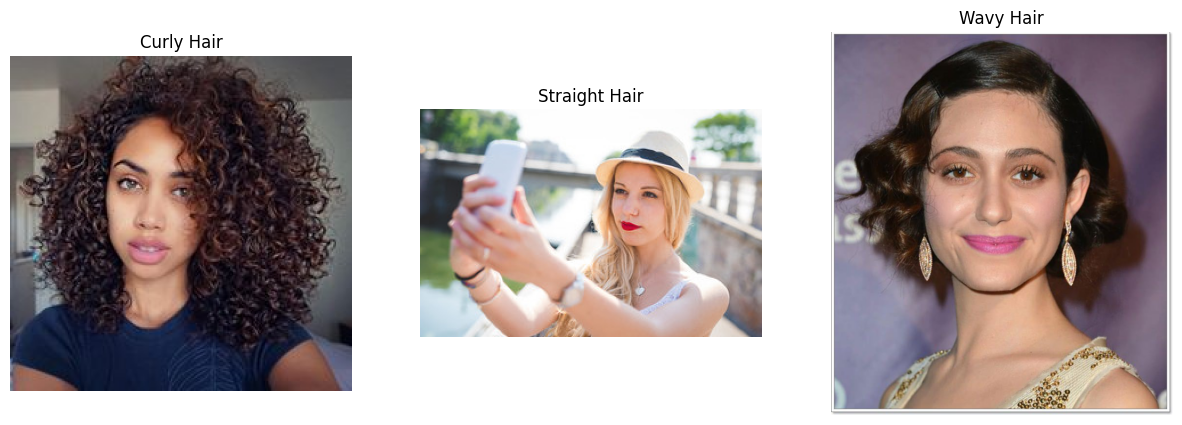

In [58]:
import matplotlib.pyplot as plt
from PIL import Image

img1 = Image.open(str(curly_hair_pics[0]))
img2 = Image.open(str(straight_hair_pics[0]))
img3 = Image.open(str(wavy_hair_pics[0]))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('Curly Hair')

plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Straight Hair')

plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.axis('off')
plt.title('Wavy Hair')

plt.show()

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (256, 256)
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

Found 986 files belonging to 3 classes.
Using 789 files for training.
Found 986 files belonging to 3 classes.
Using 197 files for validation.


In [60]:
hair_types_labels = [label.replace("_", " ") for label in train_ds.class_names]

In [61]:
def apply_sobel_edges(images):
    sobel_edges = tf.image.sobel_edges(images)
    sobel_edges = tf.sqrt(tf.reduce_sum(tf.square(sobel_edges), axis=-1))

    return sobel_edges


def preprocessing(image, label):
    image = apply_sobel_edges(image)

    return image, label


train_ds = train_ds.map(preprocessing)
val_ds = val_ds.map(preprocessing)

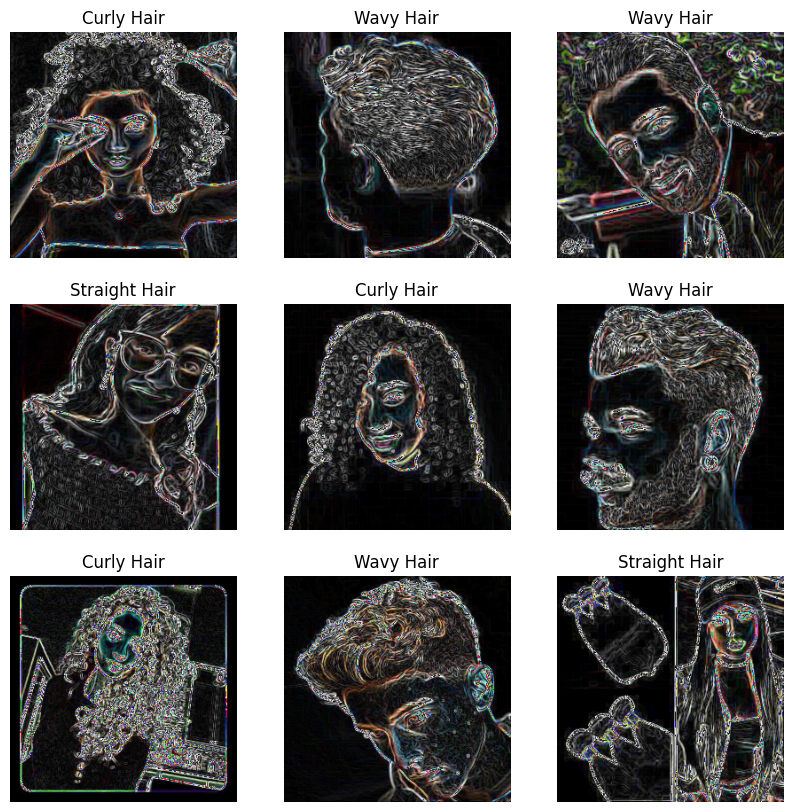

In [62]:
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(hair_types_labels[int(np.argmax(labels[i]))])
        plt.axis("off")
plt.show()

In [63]:

from keras.models import Sequential

model = Sequential()
model.add(keras.Input(shape=image_size + (3,)))
model.add(layers.Rescaling(1.0/255))

model.add(layers.Conv2D(filters=16, kernel_size=16,
          strides=2, padding='valid', dilation_rate=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=32, kernel_size=8,
          strides=2, padding='valid', dilation_rate=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=64, kernel_size=4,
          strides=2, padding='valid', dilation_rate=1))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(filters=128, kernel_size=2,
          strides=2, padding='valid', dilation_rate=1))
model.add(layers.Activation('relu'))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Flatten())

model.add(layers.Dense(64))
model.add(layers.Dropout(0.5))
model.add(layers.Activation("relu"))

model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))


# tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

In [64]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 121, 121, 16)   │        12,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 121, 121, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 121, 121, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 27, 27, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 5, 5, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 1, 1, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 119,475 (466.70 KB)

 Trainable params: 119,379 (466.32 KB)

 Non-trainable params: 96 (384.00 B)

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])


augmented_train_ds = train_ds.map(

    lambda x, y: (data_augmentation(x, training=True), y))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)


epochs = 100

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
history

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 802ms/step - accuracy: 0.3578 - loss: 1.4507 - val_accuracy: 0.3401 - val_loss: 1.1023
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 714ms/step - accuracy: 0.3304 - loss: 1.2468 - val_accuracy: 0.3350 - val_loss: 1.1011
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 761ms/step - accuracy: 0.3491 - loss: 1.1808 - val_accuracy: 0.2893 - val_loss: 1.1004
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 725ms/step - accuracy: 0.4037 - loss: 1.1000 - val_accuracy: 0.2843 - val_loss: 1.1013
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 722ms/step - accuracy: 0.3719 - loss: 1.1038 - val_accuracy: 0.3452 - val_loss: 1.0992
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 723ms/step - accuracy: 0.3975 - loss: 1.0934 - val_accuracy: 0.3553 - val_loss: 1.0965
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 720ms/step - accuracy: 0.4021 - loss: 1.0792 - val_accuracy: 0.4061 - val_loss: 1.0930
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 726ms/step - accuracy: 0.3962 - loss: 1.0877 - 

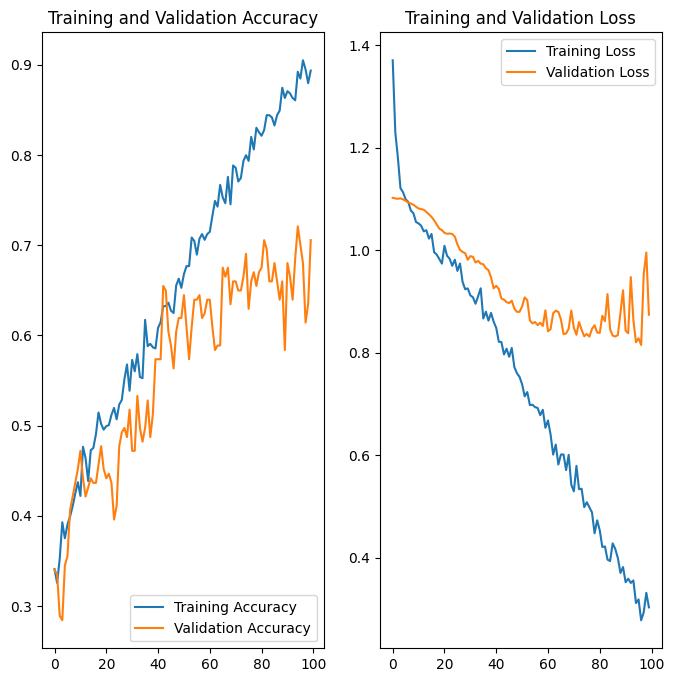

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [67]:
import numpy as np

true_labels = []
pred_labels = []

for images, labels in val_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    pred_labels.extend(np.argmax(preds, axis=1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


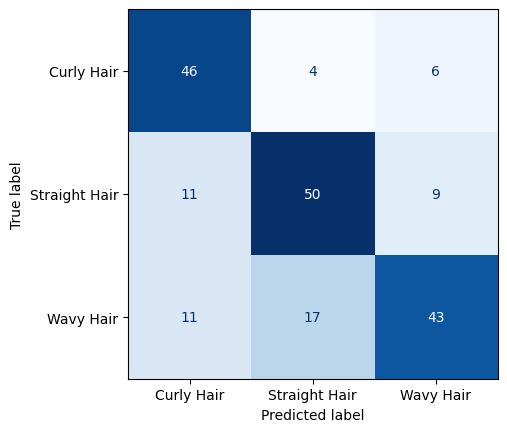

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

hair_labels_cm = ['Curly Hair', 'Straight Hair', 'Wavy Hair']

cm = confusion_matrix(true_labels, pred_labels)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=hair_labels_cm).plot(
    include_values=True, cmap='Blues', colorbar=False)

In [69]:
from sklearn.metrics import classification_report
import pandas as pd

class_report = classification_report(
    true_labels, pred_labels, target_names=hair_types_labels, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

report_df = report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])
report_df = report_df.round(2)

report_df

,precision,recall,f1-score,support
Curly Hair,0.68,0.82,0.74,56.0
Straight Hair,0.70,0.71,0.71,70.0
Wavy Hair,0.74,0.61,0.67,71.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
This image is 0.17 percent curly hair, 0.18 percent straight hair, and 0.65 percent wavy hair.


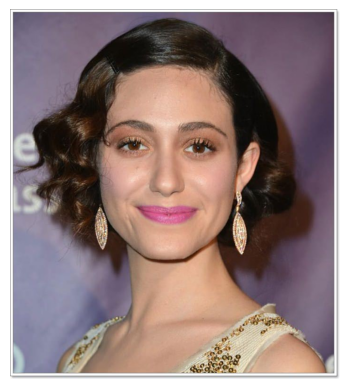

In [70]:
img_array = keras.preprocessing.image.img_to_array(img3)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)

plt.axis("off")
plt.imshow(img3)